# Base de données répertoriant les nouveaux textes législatifs (depuis 2006) en France

### Table des matières

* [Récupération et nettoyage des données de Légifrance via une API](#section1)
* [Conception des indicateurs de délinquance et criminalité](#section2)
    * [Ajout des estimations de population](#section21)
    * [Calcul des taux](#section22)
    * [Autres variables adjacentes](#section23)
* [Ajout de variables de contrôle pour une future modélisation](#section3)
    * [Densité urbaine (Table départementale)](#section31)
    * [Evolution du taux de pauvreté (Table nationale)](#section32)
* [Sauvegarde des tableaux de données finalisées](#section4)

(NB : Les liens hypertextes présents dans ce markdown et les suivants renvoient aux sites internet sur lesquelles les tableaux de données ont été téléchargées et ne correspondent pas aux URL de téléchargement, l'exécution des cellules de code permet de télécharger automatiquement les jeux de données)

Nous avons récupéré, grâce à l'open data du ministère de l'intérieur ([ici](https://www.data.gouv.fr/fr/datasets/chiffres-departementaux-mensuels-relatifs-aux-crimes-et-delits-enregistres-par-les-services-de-police-et-de-gendarmerie-depuis-janvier-1996/)) les données relatives aux crimes et délits enregistrés dans chaque département et en France entre janvier 1996 et août 2022. Ce jeu de données a été produit successivement par le Ministère de l'Intérieur puis par le SSMSI depuis sa création en 2014. 

Issu directement des applications informatiques de gestion, il n'est pas retraité et reste assez brut. Entre autres, il ne nous donne accès qu'au nombre d'infractions (classées par type) par département, nous l'avons donc complété avec des données d'estimation de population pour obtenir des taux d'infractions plutôt que des chiffres bruts. Nous avons ensuite ajouté à notre base de données des indices de localisation pour nous permettre de réaliser des représentations géographiques dans notre partie de statistiques descriptives.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Chemin vers le fichier CSV
chemin_fichier = "data/resultats_legifrance_loda.csv"
df_loda = pd.read_csv(chemin_fichier)

In [3]:
df_loda.sample()

,Titre,ID,Date,Nature,Etat,Origine,Date Publication
4236,Arrêté du 18 mars 2014 portant création d'un s...,LEGITEXT000028793846_09-08-2020,2014-03-30T00:00:00.000+0000,ARRETE,VIGUEUR,LEGI,2014-03-29T00:00:00.000+0000


In [4]:
# On met la date sous format date de pandas
df_loda['Date'] = pd.to_datetime(df_loda['Date']) 

# On ajoute la colonne mois et l'année via la variable Date (On a arbitrairement écarté Date Publication car les écarts sont de quelques jours uniquement)
df_loda['Mois'] = df_loda['Date'].dt.month.apply(lambda x: f'{x:02}')
df_loda['Année'] = df_loda['Date'].dt.year.astype(str)

df_loda.head()

,Titre,ID,Date,Nature,Etat,Origine,Date Publication,Mois,Année
0,Arrêté du 31 août 2022 fixant les niveaux de p...,LEGITEXT000046244600_21-08-2023,2022-09-01 00:00:00+00:00,ARRETE,VIGUEUR,LEGI,2022-09-01T00:00:00.000+0000,09,2022
1,Arrêté du 30 août 2022 portant création de la ...,LEGITEXT000046664861_28-08-2023,2022-12-02 00:00:00+00:00,ARRETE,VIGUEUR,LEGI,2022-12-01T00:00:00.000+0000,12,2022
2,Arrêté du 30 août 2022 portant création de la ...,LEGITEXT000046664861_02-12-2022,2022-12-02 00:00:00+00:00,ARRETE,VIGUEUR,LEGI,2022-12-01T00:00:00.000+0000,12,2022
3,Arrêté du 29 août 2022 portant création de la ...,LEGITEXT000046666903_02-12-2022,2022-12-02 00:00:00+00:00,ARRETE,VIGUEUR,LEGI,2022-12-01T00:00:00.000+0000,12,2022
4,Arrêté du 22 août 2022 fixant la liste des pos...,LEGITEXT000046230032_21-11-2022,2022-09-01 00:00:00+00:00,ARRETE,VIGUEUR,LEGI,2022-08-31T00:00:00.000+0000,09,2022


In [7]:
# Vérification pertinence des données
print("Valeurs uniques dans la colonne 'année' :")
print(df_loda['Année'].unique())

print("\nValeurs uniques dans la colonne 'mois' :")
print(df_loda['Mois'].unique())

print("\nValeurs uniques et leur fréquence dans la colonne 'Nature' :")
df_loda['Nature'].value_counts()


Valeurs uniques dans la colonne 'année' :
['2022' '2023' '2024' '2021' '2020' '2019' '2222' '2018' '2017' '2016'
 '2015' '2014' '2013' '2012' '2011' '2010' '2009' '2008' '2007' '2006']

Valeurs uniques dans la colonne 'mois' :
['09' '12' '08' '10' '07' '01' '05' '06' '04' '03' '02' '11']

Valeurs uniques et leur fréquence dans la colonne 'Nature' :


Nature
ARRETE        6790
DECRET        1826
LOI           1207
ORDONNANCE     174
DECISION         3
Name: count, dtype: int64

On se permet d'exclure pour le reste de l'étude les nouvelles normes législatives adoptées de type "décision" puisqu'elles ne sont qu'au nombre de 3 sur la période étudiée (trop faible et donc sûrement pas significatif pour le reste de l'analyse).

In [21]:
df_loda = df_loda[df_loda['Nature'] != 'DECISION']

In [8]:
def tri_occurence(df):
    '''
    Fonction récapitulative de tout le réagencement (que tu avais fait AnhLinh)
    '''
    df_résultat = df.groupby(["Année", "Mois"]).size().reset_index(name="Texte")

    types = df['Nature'].unique()

    for type in types : 
        type_lower = type.capitalize()
        grouped_type = (df[df["Nature"] == type]
            .groupby(["Année", "Mois"])
            .size()
            .reset_index(name=f"{type_lower}")
        )
        df_résultat = pd.merge(df_résultat,
                                grouped_type,
                                how="left",
                                on=["Année", "Mois"]
                            )

    # Remplacer les NaN par 0 pour les colonnes ajoutées
    df_résultat.fillna(0, inplace=True)

    # Suppression des lignes où 'Année' est 2222
    df_résultat.drop(df_résultat[df_résultat['Année'] == '2222'].index, inplace=True)

    df_résultat['day']=1
    df_résultat['Mois'] = df_résultat['Mois'].astype(int)
    df_résultat.rename(columns={'Mois': 'month'}, inplace=True) # Bizarre car le reste est en fr?
    df_résultat['Année'] = df_résultat['Année'].astype(int)
    df_résultat.rename(columns={'Année': 'year'}, inplace=True) # Bizarre car le reste est en fr?
    df_résultat.head()


    df_résultat['Date'] = pd.to_datetime(df_résultat[['year', 'month', 'day']])
    df_res = df_résultat.melt(id_vars=['year', "month", 'day', 'Date'],
                      var_name='Indicateur',  
                      value_name='Nombre')  

    df_sorted = df_res.sort_values(by='Date').reset_index(drop=True)
    df_sorted['Cumulatif'] = df_sorted.groupby('Indicateur')['Nombre'].cumsum()

    return(df_sorted)



In [ ]:
tri_occurence(df_loda)

,year,month,day,Date,Indicateur,Nombre,Cumulatif
0,2006,12,1,2006-12-01,Texte,39.0,39.0
1,2006,12,1,2006-12-01,Arrete,4.0,4.0
2,2006,12,1,2006-12-01,Loi,29.0,29.0
3,2006,12,1,2006-12-01,Decision,0.0,0.0
4,2006,12,1,2006-12-01,Ordonnance,0.0,0.0
...,...,...,...,...,...,...,...
1195,2024,11,1,2024-11-01,Decret,0.0,1824.0
1196,2024,11,1,2024-11-01,Arrete,2.0,6790.0
1197,2024,11,1,2024-11-01,Texte,2.0,9998.0
1198,2024,11,1,2024-11-01,Ordonnance,0.0,174.0


In [10]:
def nb_lignes_traitant(df, keyword, column='Titre'):
    """
    Compte le nombre de lignes dans un DataFrame où un mot clé apparaît dans une colonne donnée.
    """
    mask = df[column].str.contains(keyword, case=False, na=False)
    return mask.sum()

def filter_rows_with_keyword(df, keyword):
    """
    Filtre les lignes d'un DataFrame où un mot clé apparaît dans une colonne donnée.
    """
    filtered_df = df[df['Titre'].str.contains(keyword, case=False, na=False)]
    return filtered_df


In [11]:
keyword = 'vol'
filtered_df = filter_rows_with_keyword(df_loda, keyword)
print(len(filtered_df))

223


In [12]:
'''
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

MY_BUCKET = "anhlinh"
fs.ls(MY_BUCKET)

# Sauvegarde dans S3
MY_BUCKET = "anhlinh"
FILE_PATH_OUT_S3 = f"{MY_BUCKET}/diffusion/______.csv"

with fs.open(FILE_PATH_OUT_S3, "w") as file_out:
    _______.to_csv(file_out)

# Sauvegarde dans S3
MY_BUCKET = "anhlinh"
FILE_PATH_OUT_S3 = f"{MY_BUCKET}/diffusion/_______.csv"

with fs.open(FILE_PATH_OUT_S3, "w") as file_out:
    ______.to_csv(file_out)

fs.ls(f"{MY_BUCKET}/diffusion")
'''

'\nfs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})\n\nMY_BUCKET = "anhlinh"\nfs.ls(MY_BUCKET)\n\n# Sauvegarde dans S3\nMY_BUCKET = "anhlinh"\nFILE_PATH_OUT_S3 = f"{MY_BUCKET}/diffusion/______.csv"\n\nwith fs.open(FILE_PATH_OUT_S3, "w") as file_out:\n    _______.to_csv(file_out)\n\n# Sauvegarde dans S3\nMY_BUCKET = "anhlinh"\nFILE_PATH_OUT_S3 = f"{MY_BUCKET}/diffusion/_______.csv"\n\nwith fs.open(FILE_PATH_OUT_S3, "w") as file_out:\n    ______.to_csv(file_out)\n\nfs.ls(f"{MY_BUCKET}/diffusion")\n'

In [13]:
from visualisation import tracer_evolution_taux

In [14]:
charte_graphique_3 = {
    "Texte": "Magenta",
    "Arrete": "Green",
    "Loi": "Cyan",
    "Decret": "Pink",
    "Ordonnance": "Red",
    "Decision" : "Orange",
}

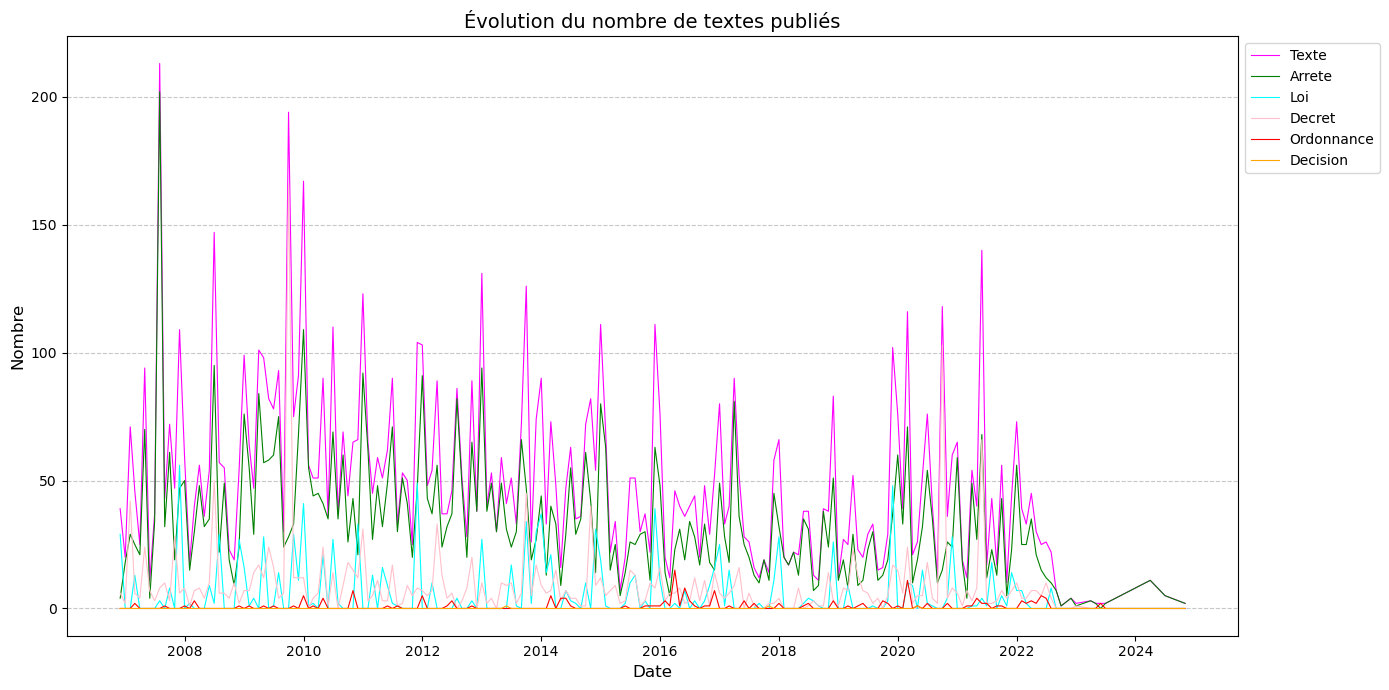

In [20]:
tracer_evolution_taux(tri_occurence(df_loda), charte_graphique_3,  taux = "Nombre", title="Évolution du nombre de textes publiés", xlabel = "Date",ylabel = "Nombre")

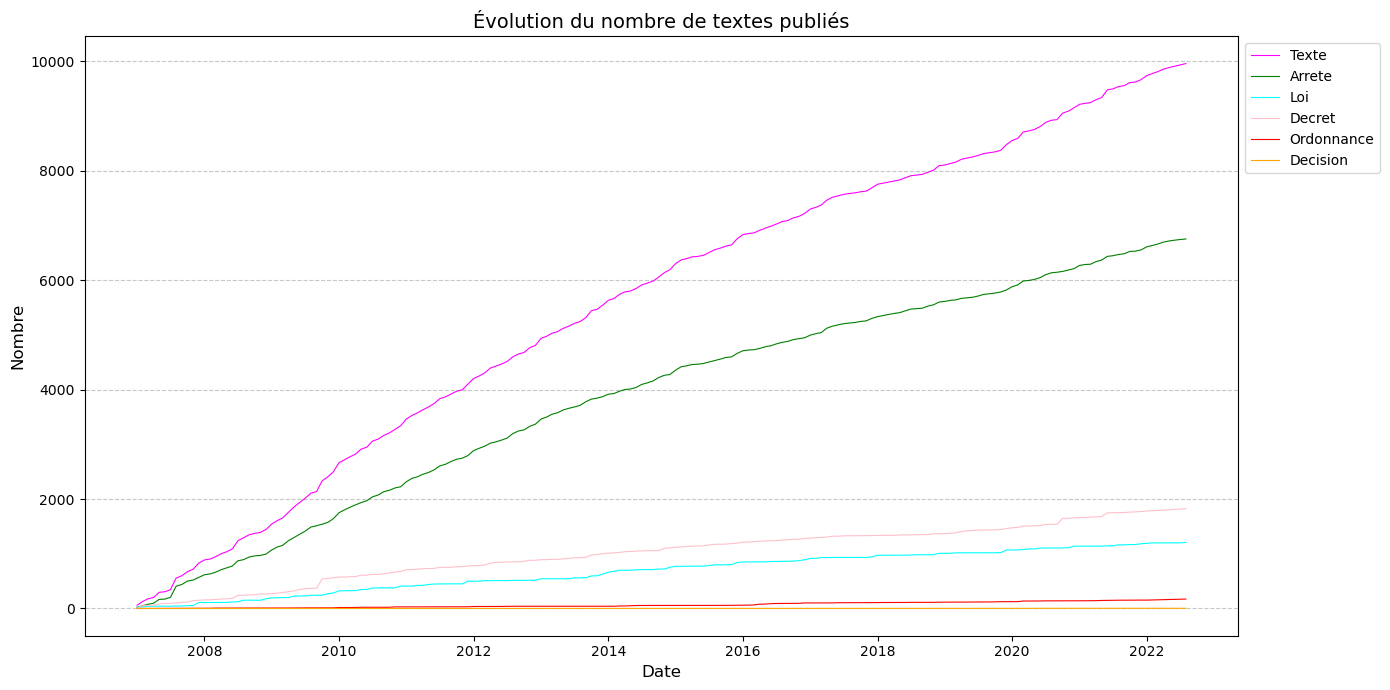

In [16]:
tracer_evolution_taux(tri_occurence(df_loda), charte_graphique_3,  taux = "Cumulatif", title="Évolution du nombre de textes publiés", xlabel = "Date",ylabel = "Nombre", time_period = ["2006-12-31", "2022-08-31"])

In [17]:
all = ["Texte", "Arrete", "Loi", "Decret", "Ordonnance", "Decision"]

In [18]:
def plot_histogram(df, types, charte_graphique_3=charte_graphique_3):
    """
    Trace un histogramme empilé du nombre de textes par mois pour différents types de textes.
    
    Parameters:
    df (DataFrame): Le DataFrame contenant les données.
    types (list): Liste des types de textes à analyser (ex: ['LOI', 'DECRET']).
    charte_graphique_3 (dict): Dictionnaire des couleurs par type de texte.
    """
    if df.empty:
        print("Il n'y a pas de donnée existante")
        return
        
    # Filtrer les données par les types de texte
    df_filtered = df[df['Indicateur'].isin(types)].copy()
    
    # S'assurer que la colonne 'Date' est de type datetime
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'], errors='coerce')
    
    # Créer un pivot table pour avoir les données dans le format requis
    df_pivot = df_filtered.pivot_table(
        index='Date',
        columns='Indicateur',
        values='Nombre',
        aggfunc='sum',
        fill_value=0
    )
    
    # Créer le graphique
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Tracer l'histogramme empilé
    bottom = np.zeros(len(df_pivot))
    bars = []
    
    for type_texte in df_pivot.columns:
        bars.append(
            ax.bar(df_pivot.index, df_pivot[type_texte], 
                  bottom=bottom, 
                  width=20, 
                  label=type_texte,
                  color=charte_graphique_3[type_texte],
                  alpha=0.7)
        )
        bottom += df_pivot[type_texte]
    
    # Ajouter des titres et des labels
    ax.set_title(f"Répartition des textes par type : {', '.join(types)}", 
                fontsize=14, pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Nombre de textes', fontsize=12)
    
    # Ajouter une légende
    ax.legend(title="Types de textes", 
             bbox_to_anchor=(1.05, 1), 
             loc='upper left')
    
    # Améliorer l'aspect du graphique
    plt.xticks(rotation=45)
    
    # Ajuster automatiquement les marges pour éviter que la légende soit coupée
    plt.tight_layout()
    
    return fig, ax

NameError: name 'np' is not defined

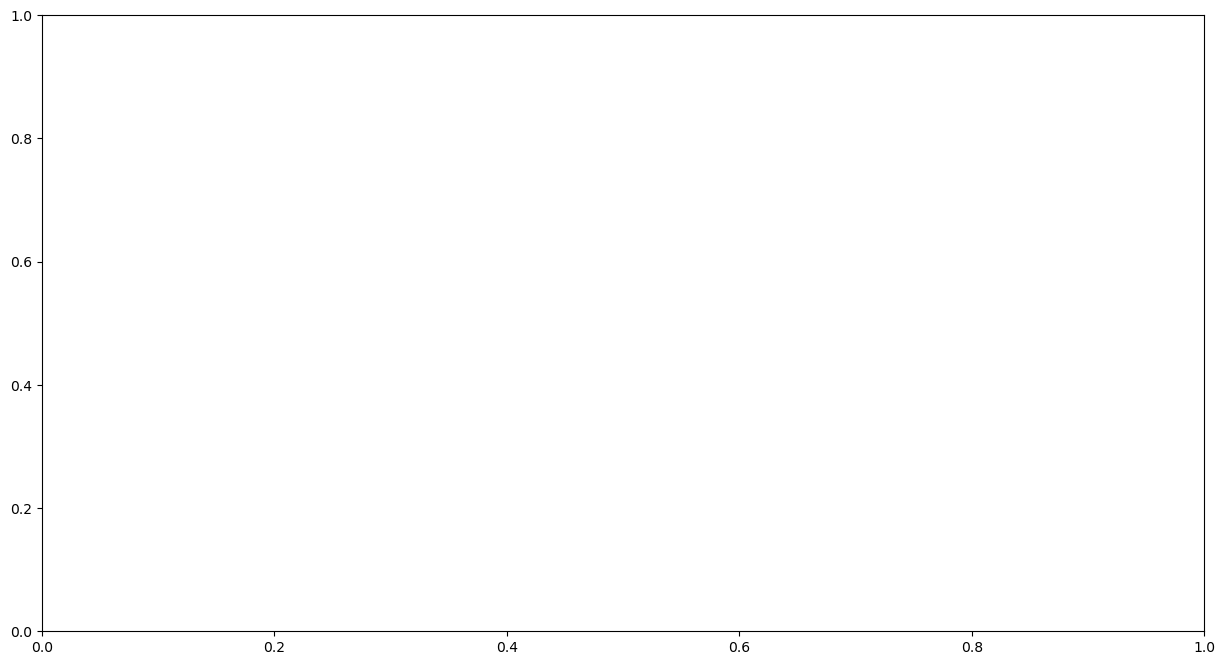

In [19]:
plot_histogram(tri_occurence(df_loda), all)

(<Figure size 1500x800 with 1 Axes>,
 <Axes: title={'center': 'Répartition des textes par type : Texte, Arrete, Loi, Decret, Ordonnance, Decision'}, xlabel='Date', ylabel='Nombre de textes'>)

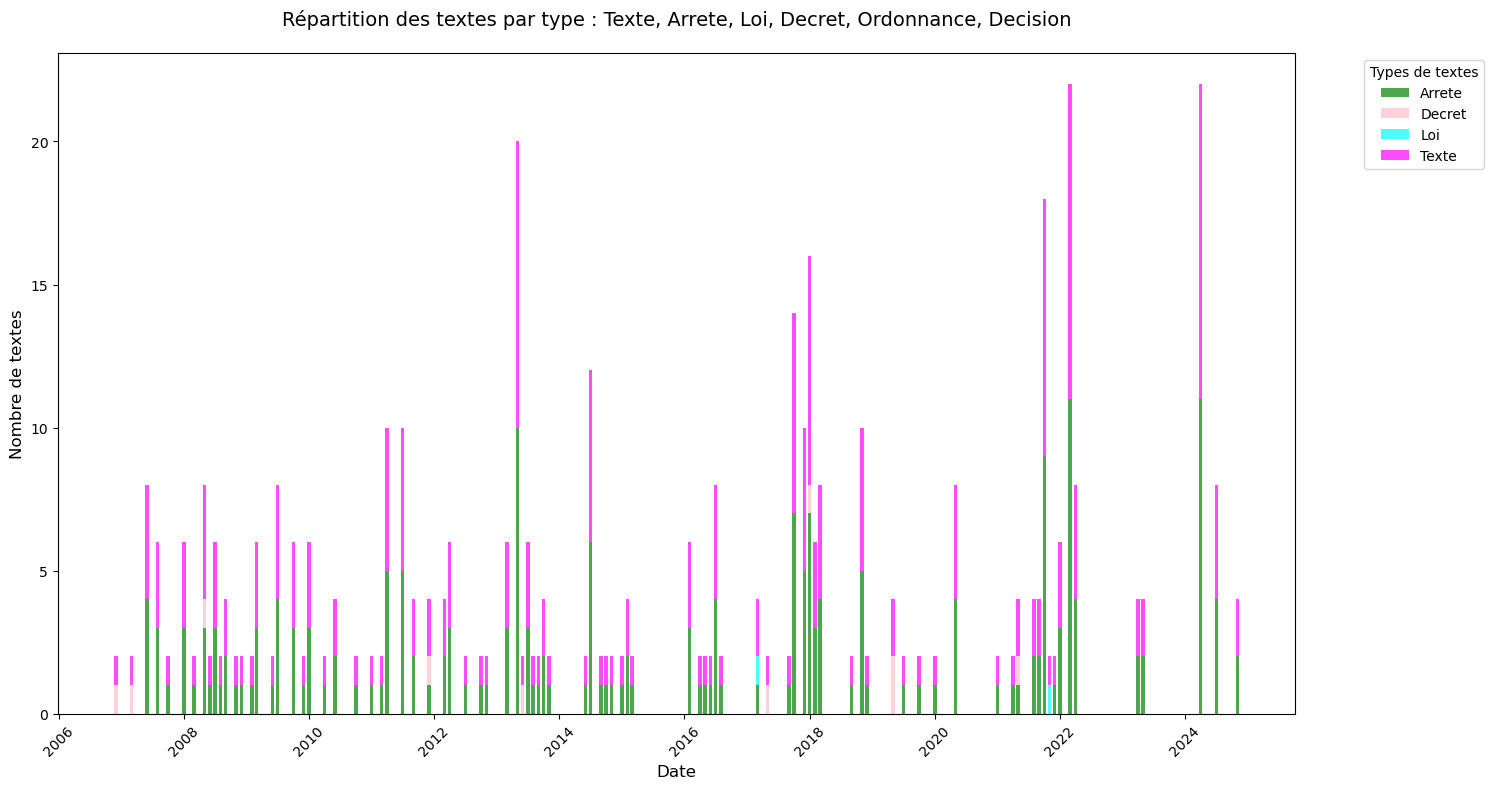

In [ ]:
plot_histogram(tri_occurence(filter_rows_with_keyword(df_loda, 'vol')), all)

Quels mots liés aux crimes et aux délits retrouvons-nous souvent dans les titres de lois?

In [ ]:
keywords_laws = [
    "vol", "infraction", "fraude", "victime", "menace", "crime", "trafic", "viol", 
    "exécution", "violence", "dégradation", "corruption", "tir", "contravention", 
    "peine", "contrefaçon", "délit", "procès-verbal", "escroquerie", "fraude fiscale", 
    "garde à vue", "responsabilité pénale", "génocide", "harcèlement", "outrage", 
    "attentat", "condamnation", "maltraitance", "dommages", "accident", "agression", 
    "meurtre", "emprisonnement", "mutilation", "exploitation", "inculpation", 
    "répression", "pillage", "racket", "intimidation", "usurpation", "abandon", 
    "violence conjugale", "attentat terroriste", "légitime défense", "banditisme", 
    "incendie criminel", "extorsion", "abus de pouvoir", "tentative de meurtre", 
    "violence policière", "assassinat", "évasion", "assistance aux criminels", 
    "falsification", "blanchiment", "punition", "récidive", "détournement", 
    "menace terroriste", "armes", "violences urbaines", "enlèvement", 
    "otage", "trahison"
]


def count_crime_keywords(df, column='Titre'):
    if df.empty:
        print("Le DataFrame est vide.")
        return
    
    all_text = ' '.join(df[column].dropna()).lower()
    word_counts = {word: all_text.count(word) for word in keywords_laws}
    
    return pd.DataFrame.from_dict(word_counts, orient='index', columns=['Fréquence']).sort_values(by='Fréquence', ascending=False)


In [ ]:
result = count_crime_keywords(df_loda)
result = result[result['Fréquence']>0]
result


,Fréquence
exploitation,637
vol,261
infraction,141
fraude,63
victime,58
répression,51
menace,47
crime,38
trafic,37
viol,33
